In [55]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset
from transformers import (
    ViltProcessor,
    ViltModel,

    PreTrainedModel,
    Trainer,
ViltForQuestionAnswering,
    TrainingArguments,
    ViltConfig
)
from transformers.modeling_outputs import SequenceClassifierOutput
from peft import get_peft_model, LoraConfig
from accelerate import Accelerator
import torch.nn as nn
import matplotlib.pyplot as plt
import nltk
nltk.download('wordnet')


2025-05-17 06:55:03.357735: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747464903.629058      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747464903.706610      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["WANDB_DISABLED"] = "true"
accelerator = Accelerator()
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")
vilt = ViltModel.from_pretrained("dandelin/vilt-b32-mlm")


preprocessor_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

In [ ]:
BASE_DIR = "/kaggle/input/final-train-val"
IMAGE_BASE_PATH = "/kaggle/input/images"

train_df = pd.read_csv(f"{BASE_DIR}/train_combined.csv")
val_df = pd.read_csv(f"{BASE_DIR}/val_combined.csv")



for df in [train_df, val_df]: 
    # Fixing backslashes to forward slashes
    df["full_image_path"] = df["full_image_path"].str.replace("\\\\", "/", regex=True)
    
    df["full_image_path"] = df["full_image_path"].apply(lambda x: os.path.join(IMAGE_BASE_PATH, x))
    df['answer'] = df['answer'].fillna('unknown')


In [15]:
train_df

,image_id,full_image_path,question,answer
0,71dvGjem6yL,/kaggle/input/images/abo-images-small/images/s...,what color is the jacket?,yellow
1,61fG7c+9CHL,/kaggle/input/images/abo-images-small/images/s...,what letter is featured?,g
2,71Cbebr-haL,/kaggle/input/images/abo-images-small/images/s...,what color is the heart?,red
3,710PsZu3byL,/kaggle/input/images/abo-images-small/images/s...,what animal is pictured?,panda
4,71IwAtqpb7L,/kaggle/input/images/abo-images-small/images/s...,is more of the animal's face visible or hidden?,hidden
...,...,...,...,...
57731,61o2GiNIYvL,/kaggle/input/images/abo-images-small/images/s...,is the letter above or below the center?,center
57732,71837m5XPdL,/kaggle/input/images/abo-images-small/images/s...,is the dog inside or outside?,outside
57733,51s13w-fNNL,/kaggle/input/images/abo-images-small/images/s...,is the image on the phone colorful?,multicolored
57734,81nOeWT-l9L,/kaggle/input/images/abo-images-small/images/s...,what is the dominant non-background color?,white


In [16]:
val_df

,image_id,full_image_path,question,answer
0,61ZB2gCav8L,/kaggle/input/images/abo-images-small/images/s...,how many feathers?,four
1,717wKcpuhTL,/kaggle/input/images/abo-images-small/images/s...,is the cover curved?,slightly
2,719VDXg5UzL,/kaggle/input/images/abo-images-small/images/s...,what shape is the cutout?,oval
3,81EHLflt8LL,/kaggle/input/images/abo-images-small/images/s...,what shape is the port?,circle
4,61O2zT0gp5L,/kaggle/input/images/abo-images-small/images/s...,what shape is the moon?,circle
...,...,...,...,...
14425,71+MsUI29+L,/kaggle/input/images/abo-images-small/images/s...,what is the color of the most prominent splatter?,yellow
14426,71MmfgL78bL,/kaggle/input/images/abo-images-small/images/s...,what color is prevalent?,orange
14427,71+I1kPwJgL,/kaggle/input/images/abo-images-small/images/s...,what color are the flowers?,pink
14428,811Y4wCRCkL,/kaggle/input/images/abo-images-small/images/s...,what background color appears near the camera?,beige


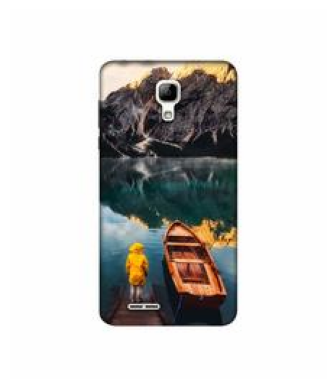

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = train_df['full_image_path'].iloc[0]
img = Image.open(img_path).convert("RGB")


plt.imshow(img)
plt.axis('off')  
plt.show()

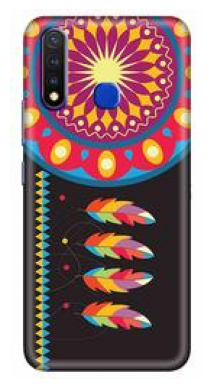

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = val_df['full_image_path'].iloc[0]
img = Image.open(img_path).convert("RGB")


plt.imshow(img)
plt.axis('off')  
plt.show()

In [ ]:
# creating the answer_to_idx mapping using unique answers from training and validation sets
all_answers = list(set(train_df['answer'].tolist() + val_df['answer'].tolist()))
answer_to_idx = {a: i for i, a in enumerate(all_answers)}

# getting the total number of unique answer classes
num_labels = len(answer_to_idx)
print("Number of classes:", num_labels)

# creating the reverse mapping from index to answer (missing in original code)
idx_to_answer = {v: k for k, v in answer_to_idx.items()}

# safely checking the answer corresponding to index 871
print("Answer for index 871:", idx_to_answer.get(871, "UNKNOWN"))


Number of classes: 1987
Answer for index 871: loop


In [ ]:
# running this where train_df exists to get all unique answers sorted
all_answers = sorted(list(set(train_df['answer'].tolist() + val_df['answer'].tolist())))

# creating a temporary mapping from answer to index
temp_mapping = {a: i for i, a in enumerate(all_answers)}

# checking the answer at index 1758, or printing 'OUT_OF_RANGE' if index is invalid
print(f"Index 1758 = {all_answers[1758] if 1758 < len(all_answers) else 'OUT_OF_RANGE'}")

# checking the answer at index 0
print(f"Index 0 = {all_answers[0]}")

# checking the answer at index 1
print(f"Index 1 = {all_answers[1]}")


Index 1758 = thicker
Index 0 = "take"
Index 1 = "takeiteasy"


In [ ]:
# this class defines a custom visual question answering (vqa) classification model built on top of the vilt architecture. 
# it inherits from the pretrained model base class and uses a specified configuration class for initialization. 
# the constructor (__init__) takes a config, a base vilt model, and the number of labels (classes) as inputs. 
# it stores these values, sets up a linear classifier layer that maps the vilt model’s hidden size to the number of output classes, 
# and keeps the config for compatibility with other utilities like peft and trainer. 
# the forward method handles inputs including token ids, pixel values, attention masks, and optionally labels for supervised learning. 
# it filters out any inputs that are None and passes the rest through the base vilt model, requesting output as a dictionary. 
# from the vilt outputs, it extracts the pooled representation of the input (typically representing the whole sequence/image). 
# this pooled output is fed into the classifier to produce logits representing class scores. 
# if labels are provided, the method computes the cross-entropy loss between the predicted logits and the true labels. 
# finally, it returns a sequence classifier output object that contains the loss (if calculated), logits, and optionally hidden states and attention maps from the base model.

class ViltForVQAClassification(PreTrainedModel):
    config_class = ViltConfig

    def __init__(self, config, base_model, num_labels):
        super().__init__(config)
        self.num_labels = num_labels
        self.vilt = base_model
        self.classifier = nn.Linear(config.hidden_size, num_labels)
        self.config = config  # Required for PEFT and Trainer

    def forward(self, input_ids=None, pixel_values=None, attention_mask=None, token_type_ids=None, labels=None, **kwargs):
        model_args = {
            'input_ids': input_ids,
            'pixel_values': pixel_values,
            'attention_mask': attention_mask,
            'token_type_ids': token_type_ids
        }
        model_args = {k: v for k, v in model_args.items() if v is not None}
        
        outputs = self.vilt(
            **model_args,
            return_dict=True
        )
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [ ]:
# defining a custom dataset class for vqa using a dataframe, processor, and answer-to-index mapping.  
# loading each image, converting to rgb, and padding/resizing to 224x224 pixels.  
# processing the image and corresponding question text into model inputs.  
# converting the answer into a tensor label based on the mapping.  
# returning a dictionary of processed inputs and labels ready for training or evaluation.

from PIL import Image, ImageOps
class VQADataset(Dataset):
    def __init__(self, df, processor, answer_to_idx):
        self.df = df
        self.processor = processor
        self.answer_to_idx = answer_to_idx

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['full_image_path']
        try:
            image = Image.open(image_path).convert("RGB")
        except:
            image = Image.new("RGB", (224, 224))  

        image = ImageOps.pad(
            image,
            size=(224, 224),
            method=Image.BICUBIC,
            color=(0, 0, 0)
        )


        encoding = self.processor(
            text=row['question'],
            images=image,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=40
        )

        if "inputs_embeds" in encoding:
            del encoding["inputs_embeds"]
            
        label = torch.tensor(self.answer_to_idx.get(row["answer"], 0), dtype=torch.long)

        item = {k: v.squeeze(0) for k, v in encoding.items()}
        item["labels"] = label
        return item

In [67]:

# Create datasets
train_dataset = VQADataset(train_df, processor, answer_to_idx)
val_dataset = VQADataset(val_df, processor, answer_to_idx)

In [68]:
# Initialize config and model
config = ViltConfig.from_pretrained("dandelin/vilt-b32-mlm", num_labels=num_labels)
model = ViltForVQAClassification(config=config, base_model=vilt, num_labels=num_labels)

In [69]:
# LoRA config and apply
lora_config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS"
)
model = get_peft_model(model, lora_config)
print("LoRA applied now")
model.print_trainable_parameters()

LoRA applied now
trainable params: 2,707,651 || all params: 115,830,662 || trainable%: 2.3376


In [ ]:
os.environ["WANDB_DISABLED"] = "true"

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=4e-5,
    logging_dir="./logs",
    logging_steps=10,
    fp16=True,
    remove_unused_columns=False,
    disable_tqdm=False,
    save_strategy="epoch",
    eval_strategy="epoch",  # Evaluate on validation set each epoch
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)


In [ ]:
!pip install bert-score

In [ ]:
from sklearn.metrics import accuracy_score
from bert_score import score as bert_score_fn

from sklearn.metrics import accuracy_score, f1_score
from nltk.corpus import wordnet

In [ ]:
# checking if the predicted word is a synonym of the label using wordnet synsets.  
# converting both prediction and label to lowercase for comparison.  
# iterating over all synsets and lemmas of the label to find a match with the prediction.  
# returning true if a synonym match is found, otherwise false.

def is_synonym(pred, label):
    pred, label = pred.lower(), label.lower()
    synsets = wordnet.synsets(label)
    for s in synsets:
        for lemma in s.lemmas():
            if pred == lemma.name().lower():
                return True
    return False

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = predictions.argmax(axis=1)

    acc = accuracy_score(labels, preds)

    # Convert label indices to text
    idx_to_answer = {v: k for k, v in answer_to_idx.items()}
    pred_texts = [idx_to_answer[p] for p in preds]
    label_texts = [idx_to_answer[l] for l in labels]

    # F1 Score (macro)
    f1 = f1_score(labels, preds, average="macro")

    # Synonym Accuracy
    synonym_correct = sum(
        pred == label or is_synonym(pred, label)
        for pred, label in zip(pred_texts, label_texts)
    )
    synonym_acc = synonym_correct / len(pred_texts)

    # BERTScore
    use_bert_score = True
    bert_precision = bert_recall = bert_f1 = 0.0
    if use_bert_score:
        P, R, F1 = bert_score_fn(pred_texts, label_texts, lang='en', verbose=True)
        bert_precision = P.mean().item()
        bert_recall = R.mean().item()
        bert_f1 = F1.mean().item()

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score (macro): {f1:.4f}")
    print(f"Synonym Accuracy: {synonym_acc:.4f}")
    if use_bert_score:
        print(f"BERT Precision: {bert_precision:.4f}, Recall: {bert_recall:.4f}, F1: {bert_f1:.4f}")

    return {
        "accuracy": acc,
        "f1": f1,
        "synonym_accuracy": synonym_acc,
        "bert_precision": bert_precision,
        "bert_recall": bert_recall,
        "bert_f1": bert_f1,
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,  # Val dataset 
    tokenizer=processor,
    compute_metrics=compute_metrics
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


/tmp/ipykernel_116/2269512470.py:83: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [71]:
sample = train_dataset[0]
print(sample.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'pixel_mask', 'labels'])


In [ ]:
# Training
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Synonym Accuracy,Bert Precision,Bert Recall,Bert F1
1,3.367900,3.134512,0.354608,0.012380,0.364865,0.989793,0.983222,0.986271
2,2.562500,2.699766,0.435204,0.023263,0.445045,0.989205,0.983988,0.986363
3,3.001500,2.467088,0.468884,0.035846,0.479764,0.989041,0.984761,0.986665
4,2.110300,2.321940,0.496535,0.051445,0.507831,0.989612,0.985919,0.987550
5,2.379400,2.231707,0.516355,0.059584,0.528898,0.989534,0.986247,0.987677
6,1.927200,2.175604,0.518087,0.065746,0.530977,0.989184,0.986317,0.987539
7,1.958800,2.133673,0.531809,0.073568,0.544421,0.990032,0.986836,0.988236
8,1.511700,2.100969,0.540402,0.082354,0.553361,0.989456,0.986915,0.987978
9,1.739100,2.082793,0.543590,0.085136,0.557519,0.989819,0.987094,0.988257
10,1.997200,2.074575,0.544629,0.084120,0.557866,0.989838,0.987078,0.988257


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/17 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/226 [00:00<?, ?it/s]

done in 2.65 seconds, 5440.83 sentences/sec
Accuracy: 0.3546
F1 Score (macro): 0.0124
Synonym Accuracy: 0.3649
BERT Precision: 0.9898, Recall: 0.9832, F1: 0.9863


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/17 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/226 [00:00<?, ?it/s]

done in 2.68 seconds, 5378.63 sentences/sec
Accuracy: 0.4352
F1 Score (macro): 0.0233
Synonym Accuracy: 0.4450
BERT Precision: 0.9892, Recall: 0.9840, F1: 0.9864


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/17 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/226 [00:00<?, ?it/s]

done in 2.68 seconds, 5378.89 sentences/sec
Accuracy: 0.4689
F1 Score (macro): 0.0358
Synonym Accuracy: 0.4798
BERT Precision: 0.9890, Recall: 0.9848, F1: 0.9867


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/17 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/226 [00:00<?, ?it/s]

done in 2.69 seconds, 5370.81 sentences/sec
Accuracy: 0.4965
F1 Score (macro): 0.0514
Synonym Accuracy: 0.5078
BERT Precision: 0.9896, Recall: 0.9859, F1: 0.9875


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/17 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/226 [00:00<?, ?it/s]

done in 2.66 seconds, 5416.78 sentences/sec
Accuracy: 0.5164
F1 Score (macro): 0.0596
Synonym Accuracy: 0.5289
BERT Precision: 0.9895, Recall: 0.9862, F1: 0.9877


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/17 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/226 [00:00<?, ?it/s]

done in 2.71 seconds, 5322.58 sentences/sec
Accuracy: 0.5181
F1 Score (macro): 0.0657
Synonym Accuracy: 0.5310
BERT Precision: 0.9892, Recall: 0.9863, F1: 0.9875


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/17 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/226 [00:00<?, ?it/s]

done in 2.66 seconds, 5421.01 sentences/sec
Accuracy: 0.5318
F1 Score (macro): 0.0736
Synonym Accuracy: 0.5444
BERT Precision: 0.9900, Recall: 0.9868, F1: 0.9882


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/17 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/226 [00:00<?, ?it/s]

done in 2.69 seconds, 5373.24 sentences/sec
Accuracy: 0.5404
F1 Score (macro): 0.0824
Synonym Accuracy: 0.5534
BERT Precision: 0.9895, Recall: 0.9869, F1: 0.9880


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/17 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/226 [00:00<?, ?it/s]

done in 2.65 seconds, 5447.76 sentences/sec
Accuracy: 0.5436
F1 Score (macro): 0.0851
Synonym Accuracy: 0.5575
BERT Precision: 0.9898, Recall: 0.9871, F1: 0.9883


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/17 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/226 [00:00<?, ?it/s]

done in 2.65 seconds, 5440.85 sentences/sec
Accuracy: 0.5446
F1 Score (macro): 0.0841
Synonym Accuracy: 0.5579
BERT Precision: 0.9898, Recall: 0.9871, F1: 0.9883


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


TrainOutput(global_step=72170, training_loss=2.2781769370081286, metrics={'train_runtime': 19160.7216, 'train_samples_per_second': 30.132, 'train_steps_per_second': 3.767, 'total_flos': 1.27974348356736e+16, 'train_loss': 2.2781769370081286, 'epoch': 10.0})

In [77]:
trainer.save_model("./finee_tuned_final-VILT-_vqa_lora")
print("Model saved to './finee_tuned_VILT_vqa_lora'")

Model saved to './finee_tuned_VILT_vqa_lora'


In [ ]:
# Zip results 
os.system("zip -r viltt_final_model.zip ./results")
# Clickable download link
display(FileLink("viltt_final_model.zip"))

updating: results/ (stored 0%)
updating: results/checkpoint-72170/ (stored 0%)
updating: results/checkpoint-72170/training_args.bin (deflated 52%)
updating: results/checkpoint-72170/scaler.pt (deflated 60%)
updating: results/checkpoint-72170/tokenizer_config.json (deflated 75%)
updating: results/checkpoint-72170/preprocessor_config.json (deflated 51%)
updating: results/checkpoint-72170/rng_state.pth (deflated 25%)
updating: results/checkpoint-72170/README.md (deflated 66%)
updating: results/checkpoint-72170/tokenizer.json (deflated 71%)
updating: results/checkpoint-72170/adapter_model.safetensors (deflated 7%)
updating: results/checkpoint-72170/special_tokens_map.json (deflated 80%)
updating: results/checkpoint-72170/scheduler.pt (deflated 55%)
updating: results/checkpoint-72170/adapter_config.json (deflated 54%)
updating: results/checkpoint-72170/vocab.txt (deflated 53%)
updating: results/checkpoint-72170/optimizer.pt (deflated 7%)
updating: results/checkpoint-72170/trainer_state.json

0

In [ ]:
from IPython.display import FileLink
os.system("zip -r viltt_final_model.zip ./results")
# Clickable download link
display(FileLink("viltt_final_model.zip"))


updating: results/ (stored 0%)
updating: results/checkpoint-72170/ (stored 0%)
updating: results/checkpoint-72170/training_args.bin (deflated 52%)
updating: results/checkpoint-72170/scaler.pt (deflated 60%)
updating: results/checkpoint-72170/tokenizer_config.json (deflated 75%)
updating: results/checkpoint-72170/preprocessor_config.json (deflated 51%)
updating: results/checkpoint-72170/rng_state.pth (deflated 25%)
updating: results/checkpoint-72170/README.md (deflated 66%)
updating: results/checkpoint-72170/tokenizer.json (deflated 71%)
updating: results/checkpoint-72170/adapter_model.safetensors (deflated 7%)
updating: results/checkpoint-72170/special_tokens_map.json (deflated 80%)
updating: results/checkpoint-72170/scheduler.pt (deflated 55%)
updating: results/checkpoint-72170/adapter_config.json (deflated 54%)
updating: results/checkpoint-72170/vocab.txt (deflated 53%)
updating: results/checkpoint-72170/optimizer.pt (deflated 7%)
updating: results/checkpoint-72170/trainer_state.json

/kaggle/working/viltt_final_model.zip

In [ ]:
model_path = "/kaggle/working/finee_tuned_final-VILT-_vqa_lora" 
print("Files in model directory:")
print(os.listdir(model_path))


Files in model directory:
['training_args.bin', 'tokenizer_config.json', 'preprocessor_config.json', 'README.md', 'tokenizer.json', 'adapter_model.safetensors', 'special_tokens_map.json', 'adapter_config.json', 'vocab.txt']
